In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Attention
from keras import Input
from tensorflow.keras.models import Sequential, Model
import keras
from tqdm import tqdm
import matplotlib.pyplot as plt

print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")

Tensorflow version: 2.10.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Read and preprocess dataset

In [2]:
data = pd.read_csv('../kaggle/input/ner_datasetreference.csv', encoding = 'unicode_escape')
data[:40]

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [3]:
data['Sentence #'] = data['Sentence #'].fillna(method='ffill')
data['Sentence #'] = data['Sentence #'].str.replace('Sentence: ', '').astype(int)
data = data.rename(columns={'Sentence #': 'Sentence'})
data = data[['Sentence', 'Word', 'Tag']]
data[:30]

,Sentence,Word,Tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O
5,1,through,O
6,1,London,B-geo
7,1,to,O
8,1,protest,O
9,1,the,O


In [4]:
print(f"Number of unique entities: {len(data['Tag'].unique())}")
data['Tag'].unique()

Number of unique entities: 17


array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [5]:
words = list(set(data['Word'].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data['Tag'].values))
num_tags = len(tags)

To obtain only useful for us data we can build a SentenceGetter class object, which will parse dataset and give us processed sentences to work with.

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s['Word'].values.tolist(), s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence').apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

# Init SentenceGetter object to preprocess and parse dataset into separate sentences
# 'sentences' object is an array of arrays, which contains tuples of word-entity pairs
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[:1]

[[('Thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('London', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('Iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('British', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')]]

At last, we should separate obtained sentences to the training and testing parts in relation 9:1 respectively.

In [7]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

max_len = data.groupby(['Sentence'], sort=False).size().max()

x = [[word2idx[w[0]] for w in s] for s in sentences]
x = pad_sequences(maxlen=max_len, sequences=x, padding="post", value=word2idx["ENDPAD"])

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['O'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [8]:
sentences[:2]

[[('Thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('London', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('Iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('British', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')],
 [('Families', 'O'),
  ('of', 'O'),
  ('soldiers', 'O'),
  ('killed', 'O'),
  ('in', 'O'),
  ('the', 'O'),
  ('conflict', 'O'),
  ('joined', 'O'),
  ('the', 'O'),
  ('protesters', 'O'),
  ('who', 'O'),
  ('carried', 'O'),
  ('banners', 'O'),
  ('with', 'O'),
  ('such', 'O'),
  ('slogans', 'O'),
  ('as', 'O'),
  ('"', 'O'),
  ('Bush', 'B-per'),
  ('Number', 'O'),
  ('One', 'O'),
  ('Terrorist', 'O'),
  ('"', 'O'),
  ('and', 'O'),
  ('"', 'O'),
  ('Stop', 'O'),
  ('the', 'O'),
  ('Bombings', 'O'),
  ('.', 'O'),
  ('"', 'O')]]

## Model definition

For a NER task we created a NN using 2x BidirectionalLSTM (BiLSTM) to find the relation and the context between words and their position in the text. There are 2 of them (BiLSTM) because if we will increase the number of unitsof the layer, it will process more words and find more relations, but quality will be lower (less training time). Therefore we decided to add anothe layer after a Dropout, so the NN will be able to train longer and to find more reliable connectiuions between words. Besides that, NN contains an Embedding layer to reduce a dimensionality of an input vector. At last, we have used an Attention layer to emphasize the most important words relations obtained from BiLSTM, which will be processed by Dense layers after that.

In [9]:
def build_model(dropout, optimizer_name, learning_rate):
    input_layer = Input(shape=(max_len,))
    embed = Embedding(input_dim=len(words), output_dim=100, input_length=max_len)(input_layer)
    rnn_1 = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0))(embed)
    rnn_drop = Dropout(dropout)(rnn_1)
    rnn_2 = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0))(rnn_drop)
    attention = Attention()([rnn_2, rnn_2])
    dense_1 = TimeDistributed(Dense(len(tags) * 4, activation="relu"))(rnn_2)
    dense_2 = TimeDistributed(Dense(len(tags) * 2, activation="relu"))(dense_1)
    out = keras.layers.Dense(units=len(tags), activation='softmax')(dense_2)
    
    
    model = Model(input_layer, out)
    
    model.summary()

    if optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    elif optimizer_name == "Nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate)

    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

**Note**: we've encountered a strange problem (probably bug with wandb/tensorflow), when EarlyStopping was freezing a sweep after a first run. There was no error, and program wasn't stopping as well. Sadly, we were unable to fix that, and had to remove this part of the code temporarily. Therefore we have found out, that in average model began to overfit after 6th - 7th epoch, so we set the epoch number for a sweep to the constant value.

In [11]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=0)

def train():    
    config_defaults = {
        'dropout': 0,
        'batch_size_divisor': 4,
        'optimizer': 'Adam',
        'learning_rate': 0.01,
        'epochs': 1
    }

    wandb.init(config=config_defaults)

    config = wandb.config
    
    with strategy.scope():
        model = build_model(config.dropout, config.optimizer, config.learning_rate)

        history = model.fit(
            x=x_train,
            y=y_train,
            validation_split=0.1,
            batch_size=int(max_len/config.batch_size_divisor),
            epochs=config.epochs,
            verbose=1,
            callbacks=[
                early_stop,
                WandbCallback()
            ]
        )

    metrics = {
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1],
    }

    wandb.log(metrics)

#     print(config)

For the sweep we have selected the following hyperparameters:
 - dropout rate
 - divisor for a batch size (since there is no need to process hunderds of words, as there will be no relation in a such a long sequence)
 - optimizer
 - learning rate
 - number of epochs (constant due to the bug with EarlyStopping, described above)

In [ ]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'dropout': {
            'values': [0.2, 0.3, 0.4, 0.5, 0.6]
        },
        'batch_size_divisor': {
            'values': [1]
        },
        'optimizer': {
            'values': ['Nadam', 'Adam', 'RMSprop']
        },
        'learning_rate': {
            'min': 0.0001,
            'max': 0.001
        },
        'epochs': {
            'values': [6]
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

wandb.agent(sweep_id, function=train, count=8)

Create sweep with ID: 7owi962b
Sweep URL: https://wandb.ai/xkretinin/uncategorized/sweeps/7owi962b


wandb: Agent Starting Run: p4ajrvs0 with config:
wandb: 	batch_size_divisor: 1
wandb: 	dropout: 0.3
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0002603713257115396
wandb: 	optimizer: RMSprop
wandb: Currently logged in as: xkretinin. Use `wandb login --relogin` to force relogin


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 100)          3517900   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 104, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 104, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 104, 68)          13668 

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/6
332/333 [============================>.] - ETA: 0s - loss: 0.2150 - accuracy: 0.9650

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best)... Done. 0.1s


333/333 [==============================] - 68s 167ms/step - loss: 0.2150 - accuracy: 0.9650 - val_loss: 0.1057 - val_accuracy: 0.9679
Epoch 2/6
332/333 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.9777

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best)... Done. 0.1s


333/333 [==============================] - 53s 160ms/step - loss: 0.0765 - accuracy: 0.9777 - val_loss: 0.0624 - val_accuracy: 0.9829
Epoch 3/6
332/333 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9853

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best)... Done. 0.1s


333/333 [==============================] - 54s 162ms/step - loss: 0.0531 - accuracy: 0.9853 - val_loss: 0.0528 - val_accuracy: 0.9855
Epoch 4/6
332/333 [============================>.] - ETA: 0s - loss: 0.0437 - accuracy: 0.9873

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150515-p4ajrvs0\files\model-best)... Done. 0.2s


333/333 [==============================] - 55s 166ms/step - loss: 0.0437 - accuracy: 0.9873 - val_loss: 0.0438 - val_accuracy: 0.9874
Epoch 5/6
333/333 [==============================] - 28s 85ms/step - loss: 0.0368 - accuracy: 0.9892 - val_loss: 0.0459 - val_accuracy: 0.9864


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_accuracy,▁▆▇███
val_loss,█▃▂▁▁▁
accuracy,0.98919
best_epoch,3
best_val_loss,0.04382
epoch,4
loss,0.03683
val_accuracy,0.98636


wandb: Agent Starting Run: 1wau2yz9 with config:
wandb: 	batch_size_divisor: 1
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	learning_rate: 0.000636157966048447
wandb: 	optimizer: Nadam


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 100)          3517900   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 104, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 104, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 104, 68)          13668 

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best)... Done. 0.2s


333/333 [==============================] - 67s 178ms/step - loss: 0.2229 - accuracy: 0.9654 - val_loss: 0.0922 - val_accuracy: 0.9745
Epoch 2/6
333/333 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9809

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best)... Done. 0.2s


333/333 [==============================] - 57s 170ms/step - loss: 0.0650 - accuracy: 0.9809 - val_loss: 0.0543 - val_accuracy: 0.9835
Epoch 3/6
333/333 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9874

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best)... Done. 0.2s


333/333 [==============================] - 56s 168ms/step - loss: 0.0429 - accuracy: 0.9874 - val_loss: 0.0533 - val_accuracy: 0.9855
Epoch 4/6
332/333 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9905

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_150959-1wau2yz9\files\model-best)... Done. 0.2s


333/333 [==============================] - 56s 167ms/step - loss: 0.0329 - accuracy: 0.9905 - val_loss: 0.0343 - val_accuracy: 0.9905
Epoch 5/6
333/333 [==============================] - 30s 88ms/step - loss: 0.0253 - accuracy: 0.9926 - val_loss: 0.0697 - val_accuracy: 0.9810


accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,█▂▂▁▁
val_accuracy,▁▅▆█▄▄
val_loss,█▃▃▁▅▅
accuracy,0.99265
best_epoch,3
best_val_loss,0.03426
epoch,4
loss,0.02534
val_accuracy,0.98105


wandb: Agent Starting Run: btv0uzzf with config:
wandb: 	batch_size_divisor: 1
wandb: 	dropout: 0.3
wandb: 	epochs: 6
wandb: 	learning_rate: 0.000559352070120936
wandb: 	optimizer: RMSprop


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 100)          3517900   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 104, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 104, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 104, 68)          13668 

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best)... Done. 0.1s


333/333 [==============================] - 36s 84ms/step - loss: 0.1538 - accuracy: 0.9696 - val_loss: 0.0749 - val_accuracy: 0.9780
Epoch 2/6
332/333 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9858

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best)... Done. 0.2s


333/333 [==============================] - 32s 96ms/step - loss: 0.0500 - accuracy: 0.9858 - val_loss: 0.0573 - val_accuracy: 0.9835
Epoch 3/6
332/333 [============================>.] - ETA: 0s - loss: 0.0365 - accuracy: 0.9897

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best)... Done. 0.2s


333/333 [==============================] - 55s 166ms/step - loss: 0.0365 - accuracy: 0.9897 - val_loss: 0.0458 - val_accuracy: 0.9867
Epoch 4/6
332/333 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.9918

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best)... Done. 0.1s


333/333 [==============================] - 55s 164ms/step - loss: 0.0283 - accuracy: 0.9918 - val_loss: 0.0365 - val_accuracy: 0.9895
Epoch 5/6
333/333 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9932

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best)... Done. 0.2s


333/333 [==============================] - 52s 157ms/step - loss: 0.0237 - accuracy: 0.9932 - val_loss: 0.0350 - val_accuracy: 0.9894
Epoch 6/6
332/333 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.9939

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_151454-btv0uzzf\files\model-best)... Done. 0.1s


333/333 [==============================] - 45s 135ms/step - loss: 0.0210 - accuracy: 0.9939 - val_loss: 0.0278 - val_accuracy: 0.9918


accuracy,▁▆▇▇██
epoch,▁▂▄▅▇█
loss,█▃▂▁▁▁
val_accuracy,▁▄▅▇▇██
val_loss,█▅▄▂▂▁▁
accuracy,0.9939
best_epoch,5
best_val_loss,0.02783
epoch,5
loss,0.02099
val_accuracy,0.99182


wandb: Agent Starting Run: km42mwzu with config:
wandb: 	batch_size_divisor: 1
wandb: 	dropout: 0.4
wandb: 	epochs: 6
wandb: 	learning_rate: 0.00011530679810708438
wandb: 	optimizer: RMSprop


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 100)          3517900   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 104, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 104, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 104, 68)          13668 

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best)... Done. 0.1s


333/333 [==============================] - 48s 131ms/step - loss: 0.3500 - accuracy: 0.9648 - val_loss: 0.1497 - val_accuracy: 0.9678
Epoch 2/6
332/333 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9681

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best)... Done. 0.1s


333/333 [==============================] - 42s 126ms/step - loss: 0.1305 - accuracy: 0.9681 - val_loss: 0.1047 - val_accuracy: 0.9695
Epoch 3/6
332/333 [============================>.] - ETA: 0s - loss: 0.0879 - accuracy: 0.9738

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best)... Done. 0.1s


333/333 [==============================] - 42s 127ms/step - loss: 0.0879 - accuracy: 0.9738 - val_loss: 0.0774 - val_accuracy: 0.9780
Epoch 4/6
332/333 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9804

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best)... Done. 0.1s


333/333 [==============================] - 41s 122ms/step - loss: 0.0688 - accuracy: 0.9804 - val_loss: 0.0639 - val_accuracy: 0.9818
Epoch 5/6
332/333 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9832

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best)... Done. 0.2s


333/333 [==============================] - 42s 125ms/step - loss: 0.0579 - accuracy: 0.9832 - val_loss: 0.0570 - val_accuracy: 0.9834
Epoch 6/6
332/333 [============================>.] - ETA: 0s - loss: 0.0513 - accuracy: 0.9851

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152013-km42mwzu\files\model-best)... Done. 0.2s


333/333 [==============================] - 47s 141ms/step - loss: 0.0513 - accuracy: 0.9851 - val_loss: 0.0565 - val_accuracy: 0.9848


accuracy,▁▂▄▆▇█
epoch,▁▂▄▅▇█
loss,█▃▂▁▁▁
val_accuracy,▁▂▅▇▇██
val_loss,█▅▃▂▁▁▁
accuracy,0.98506
best_epoch,5
best_val_loss,0.0565
epoch,5
loss,0.05135
val_accuracy,0.98479


wandb: Agent Starting Run: cyrxwf1u with config:
wandb: 	batch_size_divisor: 1
wandb: 	dropout: 0.3
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0002976904593648314
wandb: 	optimizer: Nadam


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 100)          3517900   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 104, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 104, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 104, 68)          13668 

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best)... Done. 0.2s


333/333 [==============================] - 50s 132ms/step - loss: 0.2830 - accuracy: 0.9615 - val_loss: 0.1625 - val_accuracy: 0.9678
Epoch 2/6
332/333 [============================>.] - ETA: 0s - loss: 0.1047 - accuracy: 0.9716

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best)... Done. 0.2s


333/333 [==============================] - 43s 129ms/step - loss: 0.1047 - accuracy: 0.9716 - val_loss: 0.0834 - val_accuracy: 0.9752
Epoch 3/6
332/333 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9800

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best)... Done. 0.2s


333/333 [==============================] - 43s 129ms/step - loss: 0.0648 - accuracy: 0.9800 - val_loss: 0.0675 - val_accuracy: 0.9789
Epoch 4/6
332/333 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9843

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best)... Done. 0.2s


333/333 [==============================] - 43s 128ms/step - loss: 0.0519 - accuracy: 0.9843 - val_loss: 0.0511 - val_accuracy: 0.9846
Epoch 5/6
332/333 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.9876

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152516-cyrxwf1u\files\model-best)... Done. 0.2s


333/333 [==============================] - 43s 129ms/step - loss: 0.0422 - accuracy: 0.9876 - val_loss: 0.0473 - val_accuracy: 0.9859
Epoch 6/6
333/333 [==============================] - 24s 71ms/step - loss: 0.0331 - accuracy: 0.9906 - val_loss: 0.0525 - val_accuracy: 0.9845


accuracy,▁▃▅▆▇█
epoch,▁▂▄▅▇█
loss,█▃▂▂▁▁
val_accuracy,▁▄▅██▇▇
val_loss,█▃▂▁▁▁▁
accuracy,0.99062
best_epoch,4
best_val_loss,0.04735
epoch,5
loss,0.03306
val_accuracy,0.98449


wandb: Agent Starting Run: hq182b17 with config:
wandb: 	batch_size_divisor: 1
wandb: 	dropout: 0.4
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0009402013401109628
wandb: 	optimizer: Adam


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 100)          3517900   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 104, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 104, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 104, 68)          13668 

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best)... Done. 0.2s


333/333 [==============================] - 48s 130ms/step - loss: 0.2052 - accuracy: 0.9672 - val_loss: 0.0654 - val_accuracy: 0.9811
Epoch 2/6
332/333 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9856

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best)... Done. 0.2s


333/333 [==============================] - 41s 123ms/step - loss: 0.0492 - accuracy: 0.9856 - val_loss: 0.0412 - val_accuracy: 0.9883
Epoch 3/6
332/333 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9914

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best)... Done. 0.2s


333/333 [==============================] - 41s 123ms/step - loss: 0.0299 - accuracy: 0.9914 - val_loss: 0.0328 - val_accuracy: 0.9905
Epoch 4/6
332/333 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9936

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_152955-hq182b17\files\model-best)... Done. 0.2s


333/333 [==============================] - 41s 122ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0300 - val_accuracy: 0.9920
Epoch 5/6
333/333 [==============================] - 22s 66ms/step - loss: 0.0180 - accuracy: 0.9947 - val_loss: 0.0302 - val_accuracy: 0.9916


accuracy,▁▆▇██
epoch,▁▃▅▆█
loss,█▂▁▁▁
val_accuracy,▁▆▇███
val_loss,█▃▂▁▁▁
accuracy,0.99471
best_epoch,3
best_val_loss,0.02996
epoch,4
loss,0.01805
val_accuracy,0.99159


wandb: Agent Starting Run: tyxv81e8 with config:
wandb: 	batch_size_divisor: 1
wandb: 	dropout: 0.6
wandb: 	epochs: 6
wandb: 	learning_rate: 0.00019625462199642993
wandb: 	optimizer: RMSprop


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding (Embedding)       (None, 104, 100)          3517900   
                                                                 
 bidirectional (Bidirectiona  (None, 104, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 104, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 104, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 104, 68)          13668 

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best)... Done. 0.1s


333/333 [==============================] - 48s 126ms/step - loss: 0.2951 - accuracy: 0.9581 - val_loss: 0.1298 - val_accuracy: 0.9679
Epoch 2/6
332/333 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9736

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best)... Done. 0.1s


333/333 [==============================] - 40s 121ms/step - loss: 0.0950 - accuracy: 0.9736 - val_loss: 0.0762 - val_accuracy: 0.9784
Epoch 3/6
332/333 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9816

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best)... Done. 0.1s


333/333 [==============================] - 41s 124ms/step - loss: 0.0646 - accuracy: 0.9816 - val_loss: 0.0624 - val_accuracy: 0.9825
Epoch 4/6
332/333 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9844

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best)... Done. 0.1s


333/333 [==============================] - 41s 123ms/step - loss: 0.0535 - accuracy: 0.9844 - val_loss: 0.0542 - val_accuracy: 0.9842
Epoch 5/6
332/333 [============================>.] - ETA: 0s - loss: 0.0464 - accuracy: 0.9866

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best)... Done. 0.1s


333/333 [==============================] - 41s 124ms/step - loss: 0.0464 - accuracy: 0.9866 - val_loss: 0.0502 - val_accuracy: 0.9858
Epoch 6/6
332/333 [============================>.] - ETA: 0s - loss: 0.0419 - accuracy: 0.9878

INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets


INFO:tensorflow:Assets written to: C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best\assets
wandb: Adding directory to artifact (C:\Programming\2023-Kretinin-NER_NN_for_text_classification\notebooks\wandb\run-20230608_153339-tyxv81e8\files\model-best)... Done. 0.1s


333/333 [==============================] - 41s 122ms/step - loss: 0.0419 - accuracy: 0.9878 - val_loss: 0.0440 - val_accuracy: 0.9872


### Sweep report
The sweep report can be found at: https://api.wandb.ai/links/xkretinin/c8n50e3j

In [12]:
sweep_obj = wandb.Api().sweep('xkretinin/uncategorized/sweeps/' + sweep_id)
best_config = sweep_obj.best_run().config

print("Best run config:")
print(best_config)
print(f"Validation accuracy: {sweep_obj.best_run().summary['val_accuracy']}")

wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy


Best run config:
{'epochs': 6, 'dropout': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.000559352070120936, 'batch_size_divisor': 1}
Validation accuracy: 0.9918155074119568


## Testing the best model

In [25]:
model = build_model(best_config['dropout'], best_config['optimizer'], best_config['learning_rate'])
history = model.fit(
            x=x_train,
            y=y_train,
            validation_split=0.1,
            batch_size=int(max_len/best_config['batch_size_divisor']),
            epochs=best_config['epochs'],
            verbose=1,
            callbacks=[
                early_stop
            ]
        )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 104)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 104, 100)          3517900   
                                                                 
 bidirectional_4 (Bidirectio  (None, 104, 200)         160800    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 104, 200)          0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 104, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 104, 68)          1366

In [26]:
model.save('../models/model_general_lstm/model.h5')

with open('../models/model_general_lstm/history.pickle', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/model_general_lstm/tags.pickle', 'wb') as handle:
    pickle.dump(tags, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../models/model_general_lstm/words.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
idx2tag = {v: k for k, v in tag2idx.items()}
idx2word = {i: w for w, i in word2idx.items()}

In [28]:
def plot_history(history):
    plt.style.use('ggplot')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

As can be seen from the plots below, the model has managed to achieve ~92% accuracy on a validation dataset.

After conducted experiments we've found out that ~92% of accuracy is a limit for this dataset, since part of it seems to be annotated by another NER model (or some other ML/AI model). Therefore, it creates inconsistent relations between words, which lower the model's quality (loss and accuracy matrics value).

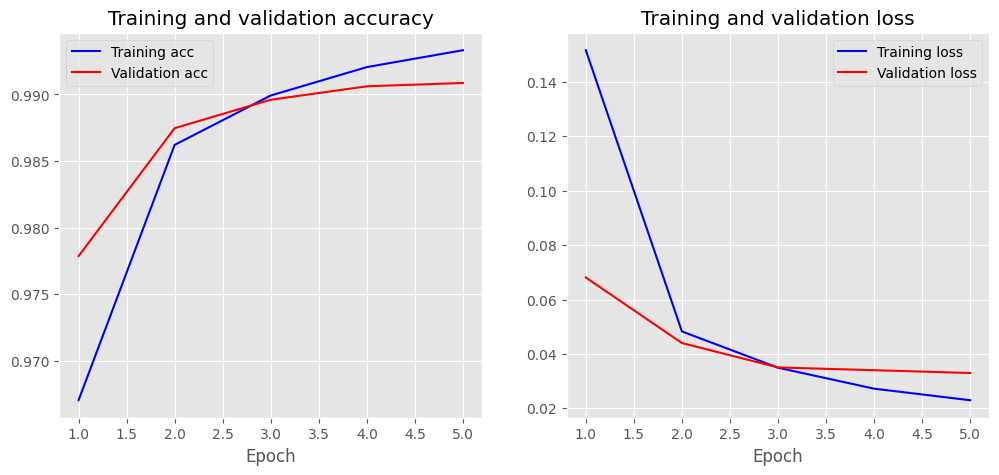

In [29]:
plot_history(history)

In [30]:
for i in range(3):
    p = model.predict(np.array([x_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
    print("-" * 30)
    for w, true, pred in zip(x_test[i], y_true, p[0]):
        if words[w] == "ENDPAD":
            break
        print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))
    print("----------------------------")

1/1 [==============================] - 1s 1s/step
Word           True 	 Pred

------------------------------
President      B-per	B-per
Bush           I-per	I-per
has            O	O
not            O	O
ruled          O	O
out            O	O
the            O	O
possibility    O	O
,              O	O
but            O	O
Vice           O	B-per
President      B-per	B-per
Dick           I-per	I-per
Cheney         I-per	I-per
said           O	O
last           O	O
week           O	O
there          O	O
are            O	O
no             O	O
plans          O	O
to             O	O
shut           O	O
it             O	O
down           O	O
.              O	O
----------------------------
1/1 [==============================] - 0s 44ms/step
Word           True 	 Pred

------------------------------
Dr.            B-per	B-per
Besigye        I-per	I-per
still          O	O
faces          O	O
civilian       O	O
charges        O	O
of             O	O
rape           O	O
and            O	O
treason        O	O
.      